In [1]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding, Dense
from keras.layers.wrappers import TimeDistributed
from keras.utils.vis_utils import plot_model
from keras.callbacks import LearningRateScheduler
import collections
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 
import os
import re
from random import randint, shuffle, seed
from keras.losses import binary_crossentropy, categorical_crossentropy, msle
from keras import backend as K
from keras.layers import Lambda,concatenate, RepeatVector
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.losses import kullback_leibler_divergence
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler(feature_range = (0, 1))
from sklearn.metrics import log_loss
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow import set_random_seed

/home/vladimir/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
seed = 17
np.random.seed = 17
set_random_seed = 17


In [0]:
!mkdir ./sequences

In [0]:

!tar xf '/content/gdrive/My Drive/data_cvae/sequences.tar.gz' -C './sequences'


In [0]:
data = []
max_seq_len = 0
seq_len = []
for file in tqdm(os.listdir('./sequences/sequences/')):
    if file.endswith('inputdata.txt'):
        curr_seq = np.loadtxt(os.path.join('./sequences/sequences/', file),delimiter=' ', dtype=np.float32)
        data.append(((np.cumsum(curr_seq[:,0:2],axis=0).astype(np.float32)) / 14) - 1)
        seq_len.append(curr_seq.shape[0])

100%|██████████| 210003/210003 [00:40<00:00, 5133.67it/s]


In [0]:
seq_len = np.array(seq_len)
max_seq_len = int(np.median(seq_len)*2)
max_seq_len

80

In [0]:
for i in range(len(data)):
    if data[i].shape[0] < max_seq_len:
        data[i] = np.concatenate([data[i], np.array([data[i][-1,:].tolist(),]*(max_seq_len - 
            data[i].shape[0]))], axis = 0 )
    else:
        data[i] = data[i][:max_seq_len]
data = np.array(data).astype(np.float32)
np.save('seq_data_scaled',data)

In [0]:
!cp seq_data_scaled.npy  '/content/gdrive/My Drive/data_cvae/'

In [0]:
if  os.path.isfile('/content/gdrive/My Drive/data_cvae/sequences/seq_data_scaled.npy'):
    data = np.load('/content/gdrive/My Drive/data_cvae/sequences/seq_data_scaled.npy')
    print("loading file")

loading file


In [6]:
latent_dim = 64
input_seq = 10
train_samples = 10
batch_size =500
test_samples = 100
lerning_rate = 1e-4

In [ ]:
x_train = data[0:60000,0:input_seq].astype(np.float32)
y_train = data[0:60000,input_seq:].astype(np.float32)
x_test = data[60000:,0:input_seq].astype(np.float32)
y_test = data[60000:,input_seq:].astype(np.float32)
out_seq = y_train.shape[1]


In [0]:
def get_kl_test_batch():
    idx_list = list(range(x_test.shape[0]))
    shuffle(idx_list);
    x_batch = x_test[idx_list[0:1000],:]
    y_batch = y_test[idx_list[0:1000],:]
    xy_batch = np.concatenate( [x_batch,y_batch], axis = 1 );
    
    return xy_batch

In [2]:
def train_gen():
    while 1:
        for i in range((x_train.shape[0]//batch_size)):
            idx = randint(0,(x_train.shape[0]//batch_size)-1)
            x_batch = x_train[i*batch_size:i*batch_size+batch_size]
            y_batch = y_train[i*batch_size:i*batch_size+batch_size]
            
            xy_batch = np.concatenate( [x_batch,y_batch], axis = 1 )
            
            x_batch = np.expand_dims(x_batch,axis=1)
            x_batch = np.repeat(x_batch, train_samples, axis=1)
            
            y_batch = np.expand_dims(y_batch,axis=1)
            y_batch = np.repeat(y_batch, train_samples, axis=1)
            
            xy_batch = np.expand_dims(xy_batch,axis=1)
            xy_batch = np.repeat(xy_batch, train_samples, axis=1)
            
            x_batch = np.reshape(x_batch,(batch_size*train_samples,input_seq,2))
            y_batch = np.reshape(y_batch,(batch_size*train_samples,out_seq,2))
            xy_batch = np.reshape(xy_batch,(batch_size*train_samples,input_seq + out_seq,2))
            
            
            
            yield ({'input_x': x_batch, 'input_xy' :  xy_batch}, {'main_out': y_batch})

In [3]:
def test_gen():
    while 1:
        for i in range(x_test.shape[0]//batch_size):
            x_batch = x_test[i*batch_size:i*batch_size+batch_size]
            x_batch = np.expand_dims(x_batch,axis=1);
            x_batch = np.repeat(x_batch, test_samples, axis=1);
            x_batch = np.reshape(x_batch,(batch_size*test_samples,input_seq,2))
                     
            
            z_sample = np.random.normal(loc=0.0, scale=1.0, size=(batch_size*test_samples, latent_dim)) 
            
            yield ({'input_x': x_batch, 'input_z' :  z_sample})

In [4]:
def bms_loss( y_true, y_pred ):
    y_true = K.reshape( y_true, (batch_size,train_samples,out_seq*2))
    y_pred = K.reshape( y_pred, (batch_size,train_samples,out_seq*2))
   
    diff = K.exp(-K.sum(K.square(y_true-y_pred),axis=-1))
    bms_loss= K.min(diff, axis=1)
  
  
  
    return K.mean(bms_loss)
    

def vae_loss(y_true, y_pred):
    
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
     
    y_true = K.reshape( y_true, (batch_size,train_samples,out_seq*2))
    y_pred = K.reshape( y_pred, (batch_size,train_samples,out_seq*2))
       
    
    recon_loss = K.sum(K.square(y_true-y_pred), axis=-1)
    
    
    recon_loss = K.mean(recon_loss, axis=-1)
        
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    
    z_mean_reshape = K.reshape(z_mean, (batch_size,train_samples,latent_dim))
    z_var_reshape = K.reshape(z_var, (batch_size,train_samples,latent_dim))
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.exp(z_var), axis=-1)
    kl_loss = K.mean(kl_loss, axis=-1)
    
    
    return K.mean(recon_loss +  kl_loss)



def sample_z(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean = args[0]
    z_var = args[1]
    
   
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_var) * epsilon


def recon_loss(y_true, y_pred):
    y_true = K.reshape( y_true, (batch_size,train_samples,out_seq*2))
    y_pred = K.reshape( y_pred, (batch_size,train_samples,out_seq*2))
       
    
    
    rec_loss = K.sum(K.square(y_true-y_pred), axis=(-1))
    return  K.mean(rec_loss)
  


def kl_loss(y_true, y_pred):
    
    kl = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.exp(z_var), axis=-1)
    kl = K.reshape(kl, (batch_size,train_samples))
    return K.mean(kl)



def get_kl_divg(args):
    p_z_mean,  p_z_var = args
    kl_div = - 0.5 * np.sum(1. + p_z_var - np.square(p_z_mean) - np.exp(p_z_var), axis=-1)
    
    return np.mean(kl_div)
    
   

In [10]:
input_x = Input(shape=(input_seq,2), name='input_x')
input_xy = Input(shape=(input_seq + out_seq,2), name='input_xy')
input_z = Input(shape=(latent_dim,), name='input_z')

EMB3 = TimeDistributed(Dense(64,activation='relu'))(input_xy)
rec = LSTM(128, implementation = 1, activation='tanh')(EMB3)
z_mean = Dense(64, activation='relu',name='mean')(rec)
z_var = Dense(64, activation='relu',name='var')(rec)
z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_var])




EMB1 = TimeDistributed(Dense(32, activation='relu'))
LSTMenc = LSTM(48, implementation = 1, activation='tanh')

EMB2 = Dense(64, activation='relu')

LSTMdec = LSTM(48, implementation = 1, return_sequences=True, activation='tanh')
dec_out = TimeDistributed(Dense(2), name='main_out')

cvae = EMB1(input_x)
cvae = LSTMenc(cvae)
cvae = concatenate([cvae, z])
cvae = EMB2(cvae)
cvae = RepeatVector(out_seq)(cvae)
cvae = LSTMdec(cvae)
cvae = dec_out(cvae)

cvae_model = Model(inputs=[input_x, input_xy], outputs=[cvae])

decoder = EMB1(input_x)
decoder = LSTMenc(decoder)
decoder = concatenate([decoder, input_z])
decoder = EMB2(decoder)
decoder = RepeatVector(out_seq)(decoder)
decoder = LSTMdec(decoder)
decoder = dec_out(decoder)

decoder_model = Model(inputs=[input_x, input_z], outputs=[decoder])

recognition_model = Model(inputs=[input_xy], outputs=[z_mean, z_var])

cvae_model.compile(optimizer = Adam(lr=lerning_rate, clipnorm=1.0), loss = vae_loss, metrics=[kl_loss])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


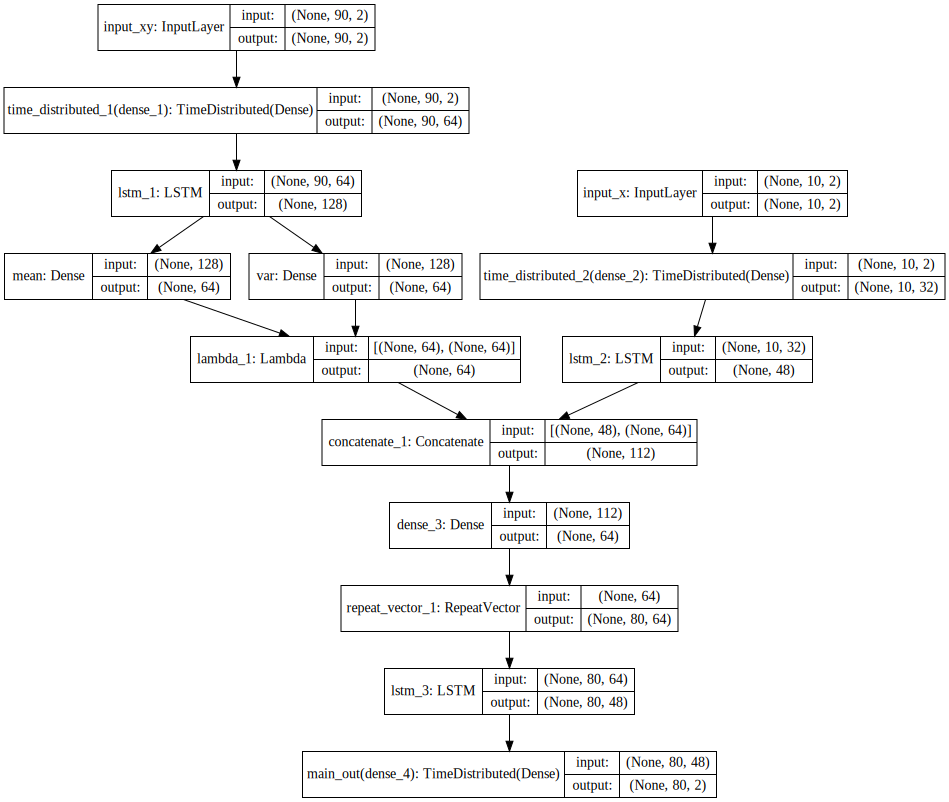

In [11]:
SVG(model_to_dot(cvae_model, show_shapes=True).create(prog='dot', format='svg'))

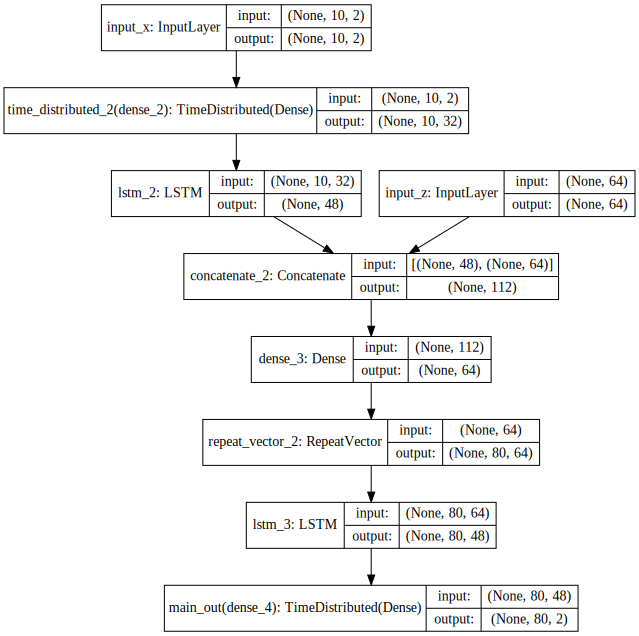

In [12]:
SVG(model_to_dot(decoder_model, show_shapes=True).create(prog='dot', format='svg'))

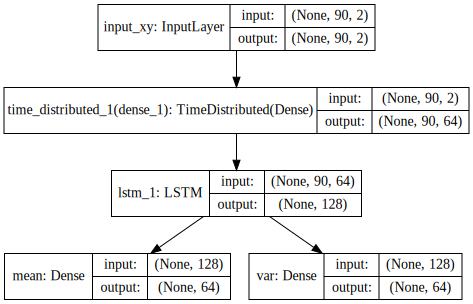

In [13]:
SVG(model_to_dot(recognition_model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
#vanila LSTM
in1 = Input(shape=(input_seq,2), name='input_x')
dec = TimeDistributed(Dense(32, activation='relu'))(in1)
dec = LSTM(48, implementation = 1, activation='tanh')(dec)
dec = Dense(64, activation='relu')(dec)
dec = RepeatVector(out_seq)(dec)
dec = LSTM(48, implementation = 1, return_sequences=True, activation='tanh')(dec)
dec = TimeDistributed(Dense(2), name='main_out')(dec)
lstm_model = Model( in1, dec)
lstm_model.compile(optimizer = Adam(lr=lerning_rate, clipnorm=1.), loss = binary_crossentropy)

In [0]:
#SVG(model_to_dot(lstm_model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
kl_test_batch = get_kl_test_batch()
#_, y_batch_test = get_test_batches()
KL_divergence = []

In [0]:
def scheduler(epoch):
    if epoch == 50:
        K.set_value(cvae_model.optimizer.lr, 1e-5)
    if epoch == 100:
        K.set_value(cvae_model.optimizer.lr, 1e-6)
  
    return K.get_value(cvae_model.optimizer.lr)

In [0]:
def NLL(y_true, y_pred):
    RSS  = np.sum(np.square(y_true - y_pred), axis=[2,3])
    var = np.sum(np.square(y_pred - np.mean(y_pred)))/ y_pred.shape[0]
    return -y_pred.shape[0]*0.5*np.log(1/(2*np.pi*var)) - RSS/(2*var)

In [0]:
best_cll = 10000.0

kl_div = 10000.0
for i in range(200):
    print('EPOCH# :',i+1)
    scheduler(i+1) # lernin rate scheduer
    cvae_model.fit_generator(train_gen(),steps_per_epoch=(x_train.shape[0]//batch_size),epochs=1,workers=1)
    preds = decoder_model.predict_generator(test_gen(), steps=(x_test.shape[0]//batch_size), workers=1,  verbose=1)
  
    kl_pred = recognition_model.predict(kl_test_batch,verbose=1)
    kl_div = get_kl_divg(kl_pred)
    KL_divergence.append(kl_div)
  
    y_batch_cll = np.expand_dims(y_test[:y_test.shape[0]//batch_size*batch_size],axis=1)
    y_batch_cll = np.repeat(y_batch_cll, test_samples, axis=1)
    y_batch_cll = np.reshape(y_batch_cll,(y_batch_cll.shape[0],test_samples,out_seq*2))
    preds_cll = np.reshape(preds,(x_test.shape[0]//batch_size*batch_size,test_samples,out_seq*2))
 
  
    cll = np.exp(np.mean(np.square(preds_cll - y_batch_cll),axis=-1))
  
    cll = np.mean(cll,axis=-1)
    cll = np.sum(cll)
    if cll < best_cll:
        best_cll = cll
    cvae_model.save('./saved_cvae_epoch#'+str(i+1)+'.h5');
  
    print('Negative CLL: ',cll)
    print('Best CLL: ', best_cll)
    print('KL divg: ',kl_div)

EPOCH# : 1
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
1000/1000 [==============================] - 2s 2ms/step
Negative CLL:  11575.299
Best CLL:  10000.0
KL divg:  1.7814571
EPOCH# : 2
Epoch 1/1
1000/1000 [==============================] - 2s 2ms/step
Negative CLL:  11399.528
Best CLL:  10000.0
KL divg:  1.6807265
EPOCH# : 3
Epoch 1/1
1000/1000 [==============================] - 2s 2ms/step
Negative CLL:  11369.359
Best CLL:  10000.0
KL divg:  1.8225192
EPOCH# : 4
Epoch 1/1
1000/1000 [==============================] - 2s 2ms/step
Negative CLL:  11327.783
Best CLL:  10000.0
KL divg:  1.8662356
EPOCH# : 5
Epoch 1/1
1000/1000 [==============================] - 2s 2ms/step
Negative CLL:  11272.391
Best CLL:  10000.0
KL divg:  1.8208096
EPOCH# : 6
Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step
Negative CLL:  11213.198
Best CLL:  10000.0
KL divg:  1.799296
EPOCH# : 7
Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step
Negative CLL:  11170.43

(10000, 100)

In [0]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scipy.cluster
%matplotlib inline

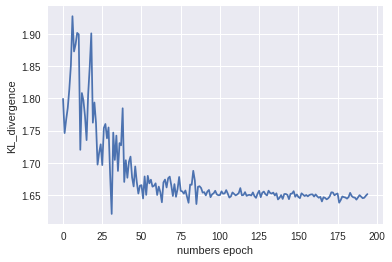

In [0]:
plt.plot(KL_divergence[5:])
plt.ylabel('KL_divergence')
plt.xlabel('numbers epoch')
plt.show()

In [0]:
def km_clusters(preds):
    n_clusters = 5;
    _data_X = np.reshape(preds,(preds.shape[0],-1))
    centroids,_ = scipy.cluster.vq.kmeans(_data_X, n_clusters)
    idx, _ = scipy.cluster.vq.vq(_data_X, centroids)

    clusters = [[] for _ in range(n_clusters)]
    for data_idx in range(preds.shape[0]):
        clusters[idx[data_idx]].append(preds[data_idx,:]);
    cluster_means = [];
    for c_idx in range(n_clusters):
        cluster_means.append( np.mean( np.array(clusters[c_idx]), axis = 0) )
    return clusters

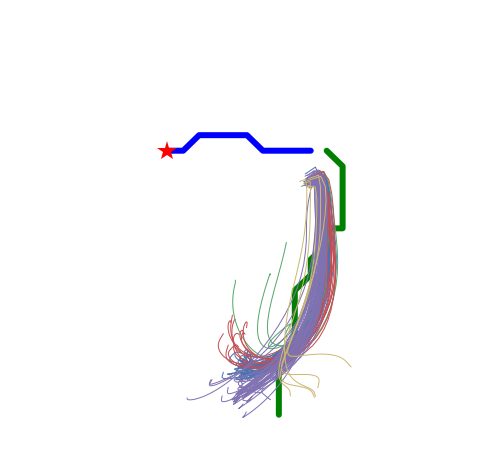

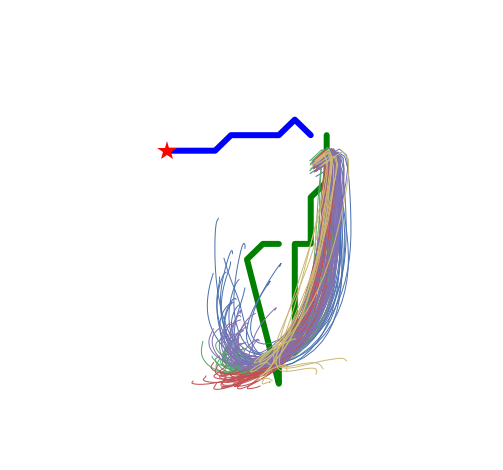

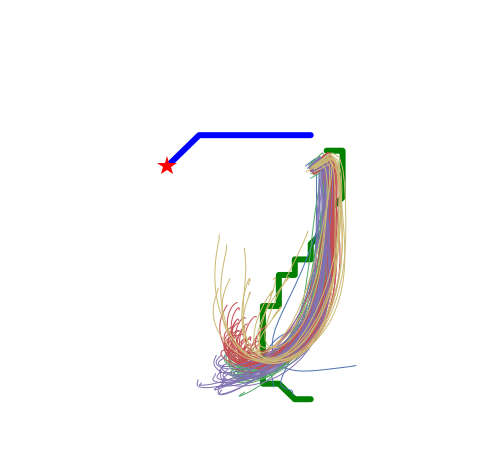

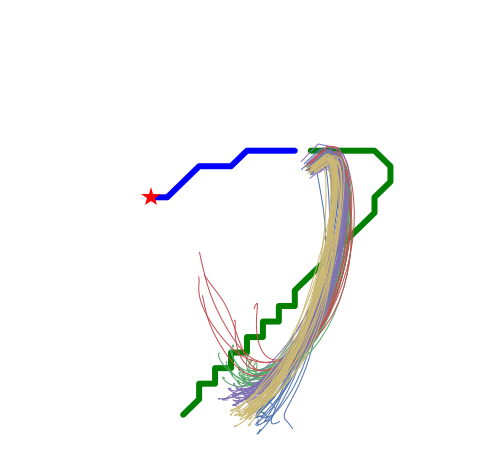

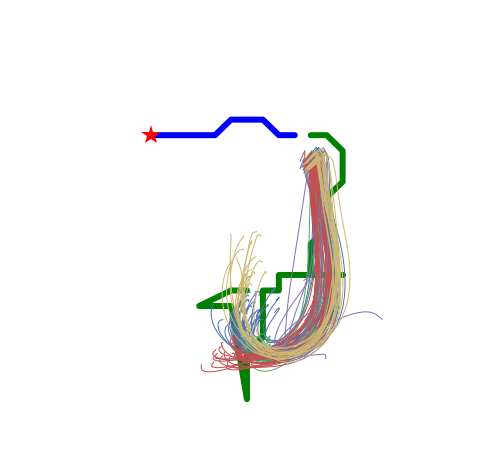

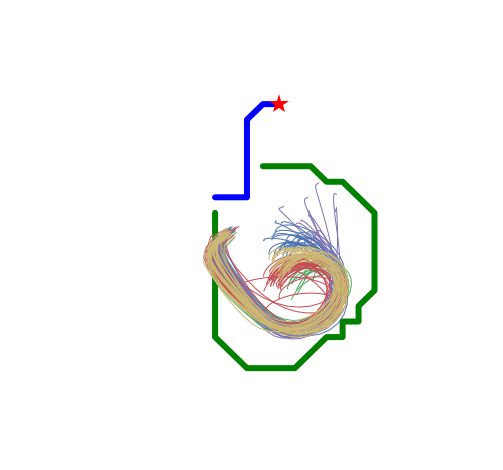

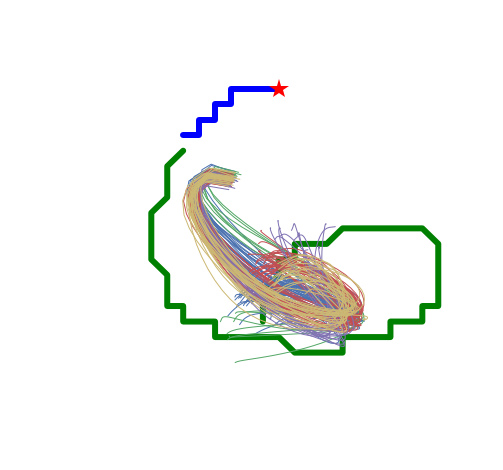

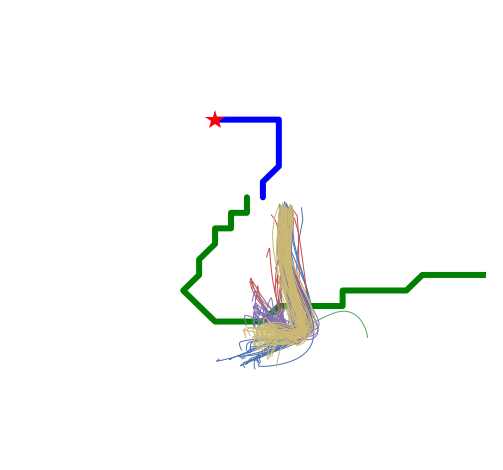

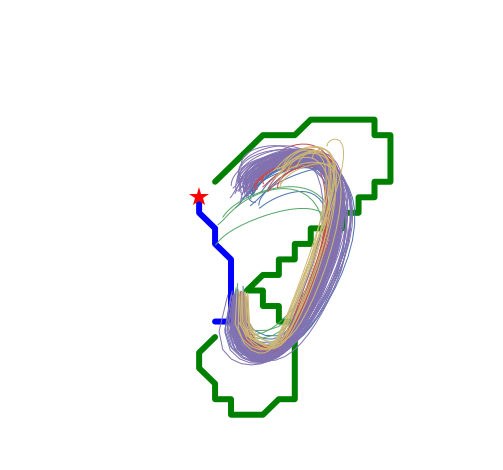

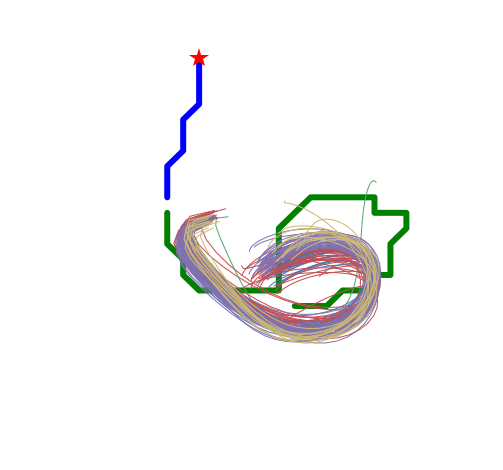

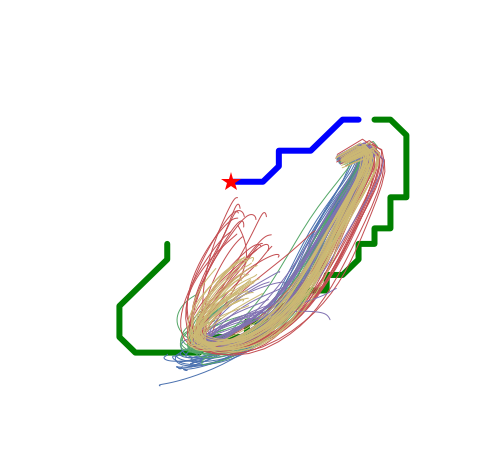

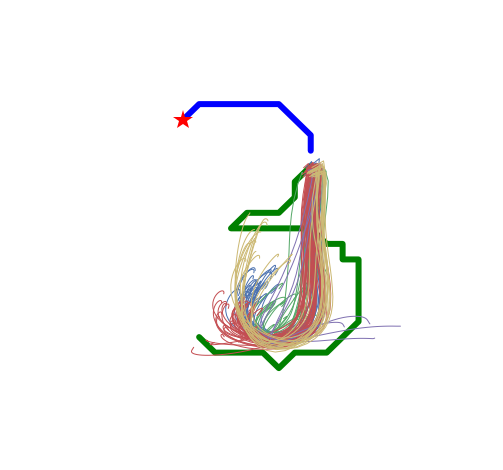

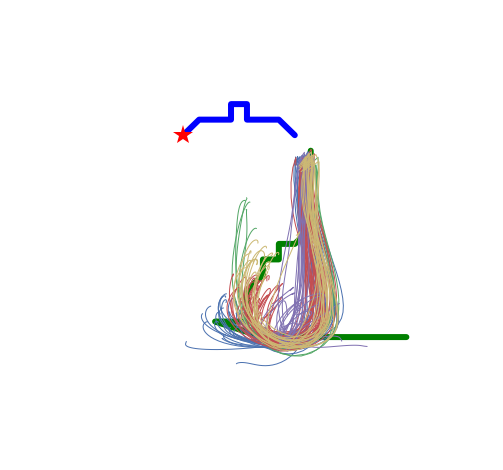

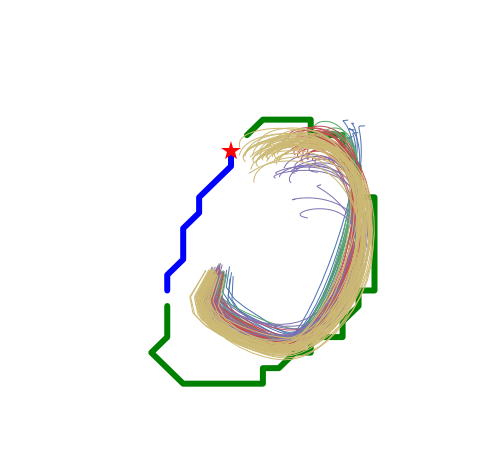

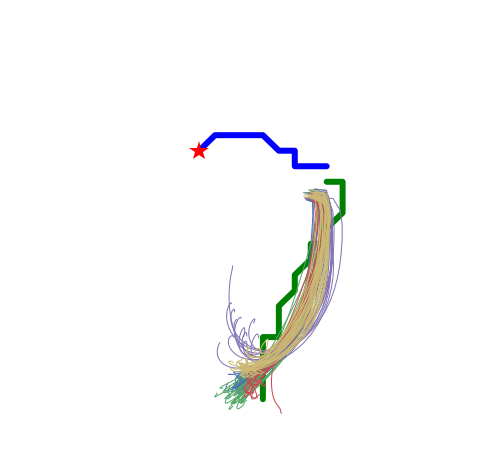

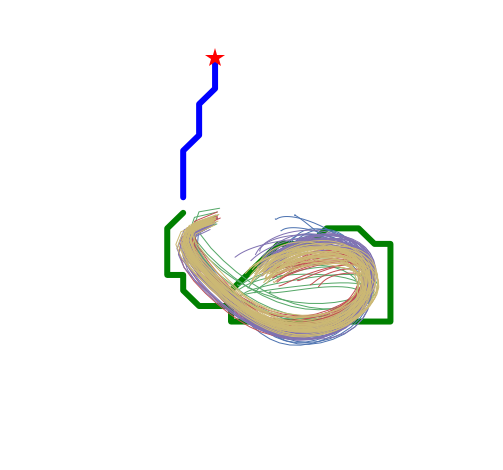

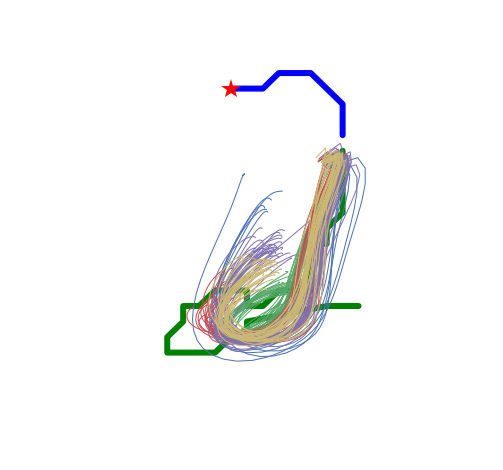

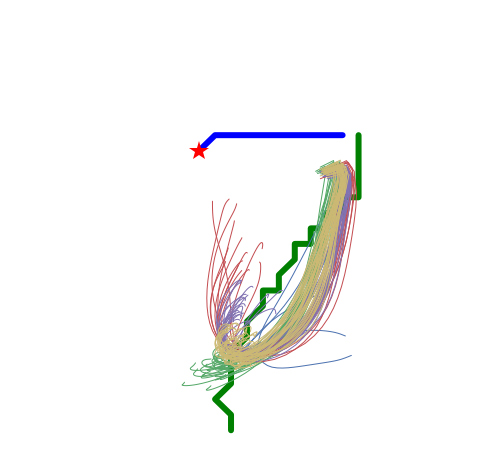

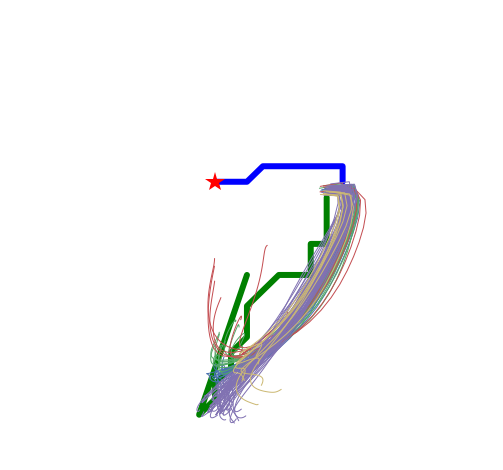

In [0]:
preds = np.reshape(preds,(x_test.shape[0],test_samples,out_seq,2))
for i in range(10,30):
    clustered_samples = km_clusters( preds[i,:] );
    plt.style.use('dark_background')
    matplotlib.style.use('seaborn')
    plt.figure(figsize=(8, 8))
    dpi = 150
    axes = plt.gca()
    axes.set_xlim([-1,1])
    axes.set_ylim([1,-1])
    axes.axis('off')
    plt.plot(x_test[i,:,0].tolist(),x_test[i,:,1].tolist(),c='b',linewidth=6)
    plt.plot(x_test[i,0,0].tolist(),x_test[i,0,1].tolist(),c='r',markersize=20,marker='*');
    plt.plot(y_test[i,:,0].tolist(),y_test[i,:,1].tolist(),c='g',linewidth=6)
    for j in range(len(clustered_samples)):
        samples_in_curr_cluster = np.array(clustered_samples[j])
        for k in range(samples_in_curr_cluster.shape[0]):
            plt.plot(samples_in_curr_cluster[k,:,0].tolist(),samples_in_curr_cluster[k,:,1],c='C'+str(j),linewidth=1)
    
plt.close()

In [0]:
!cp -r './img_cvae/' '/content/gdrive/My Drive/data_cvae/'